In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, MaxPooling2D
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Reading/Data Understanding

In [ ]:
# Establishing path to the directories we use here pathlib to create path, test_dir and train_dir

In [4]:
test_path = "/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Test"

In [3]:
train_path="/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train"

In [5]:
import pathlib

In [6]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [21]:
# Taking the count of image in test and train directories

train_count = len(list(train_dir.glob('*/*.jpg')))
train_count

2239

In [8]:
test_count=len(list(test_dir.glob('*/*.jpg')))
test_count

118

In [22]:
# Define some parameters for the loader:

image_rows, image_cols = 180,180
batch_size= 32

we use 80% images from the train dataset to train the model and other 20% to validate the model

Arguments

1. Data directory: Specifies where the data is located.
2. Labels: Determines how labels are provided, including inferred from directory structure, None, or as a list/tuple of integers.
3. Label mode: Defines label encoding as 'int', 'categorical', 'binary', or None.
4. Image settings: Includes color mode, batch size, image size, interpolation method, and shuffle option.
5. Validation and more: Offers validation split, symlink handling, and aspect ratio preservation, along with legacy keyword arguments.



# Dataset Creation

In [12]:
#Load using keras.preprocessing
#Let's load these images off disk using the helpful image_dataset_from_directory utility.
# seed set is 123

train_ds= tf.keras.preprocessing.image_dataset_from_directory(train_dir,seed=123,validation_split=0.2,
                                                              image_size=(image_rows,image_cols),
                                                              batch_size=batch_size,color_mode='rgb',
                                                              subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
#Load using keras.preprocessing
#Let's load these images off disk using the helpful image_dataset_from_directory utility.
# seed set is 123

val_ds =tf.keras.preprocessing.image_dataset_from_directory(train_dir,seed=123,
                                                            validation_split=0.2,
                                                            image_size=(image_rows,image_cols),
                                                            batch_size=batch_size,color_mode='rgb',
                                                            subset='validation',
                                                            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


# Dataset visualisation

### visualize one instance of all the nine classes present in the dataset


In [14]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

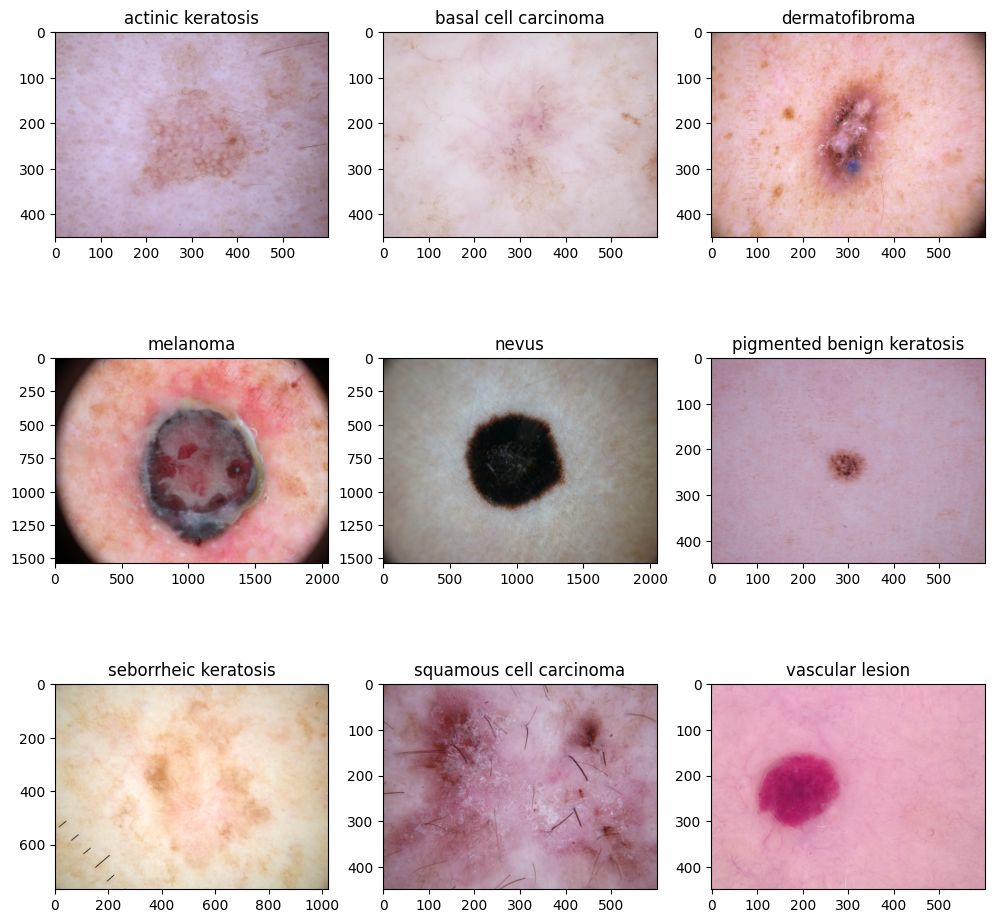

In [15]:
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [16]:
import os
import PIL

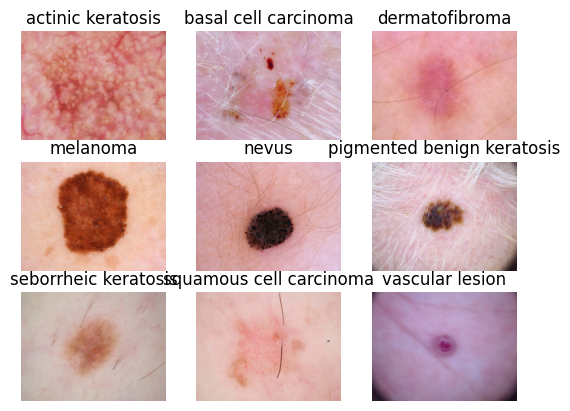

In [17]:
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

* The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

* Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

* Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

## The Model
- The input to the network is an image of dimensions (180, 180, 3). The first two layers have 32 channels of a 3*3 filter size and the same padding.
- Then after a max pool layer of stride (2, 2),
- Then a convolution layer of 32 filter size and filter size (3, 3). This is followed by a max-pooling layer of stride (2, 2)
- Then a convolution layer of filter size (3, 3) and 64 filters.This is followed by a max-pooling layer of stride (2, 2)
- Then a convolution layer of filter size (3, 3) and 64 filters.This is followed by a max-pooling layer of stride (2, 2)
- Then We flatten this output. After this there is a fully connected layer. fully connected layer is used to implement softmax function to classify 9 classes. All the hidden layers use ReLU as its activation function. ReLU is more computationally efficient because it results in faster learning and it also decreases the likelihood of vanishing gradient problems.

In [23]:
model=Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))


* We have dropout of 0.2 introduced to reduce the overfittting

## Compile Model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

We have
* Total params: 1,067,337
* Trainable params: 1,067,337

## Training Model

In [26]:
epochs= 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 966s 4s/step - loss: 2.0859 - accuracy: 0.1875 - val_loss: 2.1083 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0421 - accuracy: 0.1914 - val_loss: 2.0610 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 2.0272 - accuracy: 0.1931 - val_loss: 2.0367 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0217 - accuracy: 0.1942 - val_loss: 1.9818 - val_accuracy: 0.2528
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9542 - accuracy: 0.2422 - val_loss: 1.9147 - val_accuracy: 0.2416
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8611 - accuracy: 0.3075 - val_loss: 1.7615 - val_accuracy: 0.3915
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.8881 - accuracy: 0.2907 - val_loss: 1.8377 - val_accuracy: 0.3132
Epoch 8/20
56/56 [======

## Visualising Results

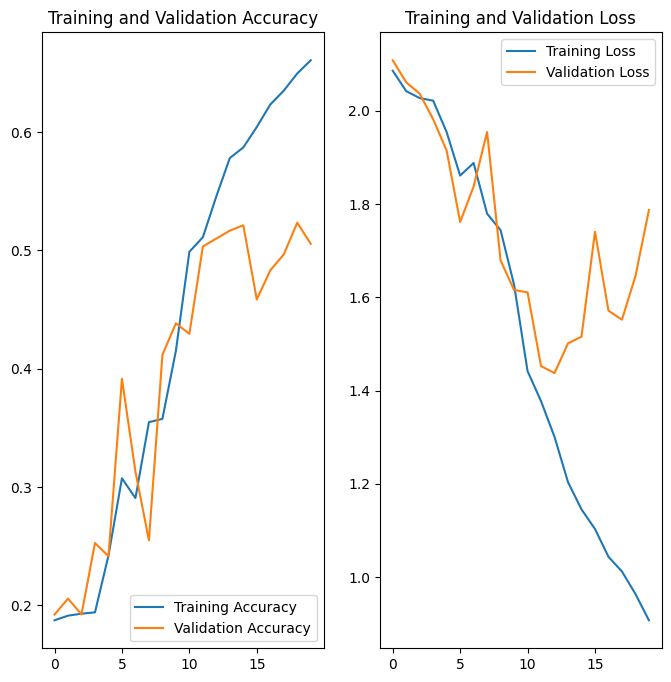

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Key Observations
*   The training and validation accuracy are 66% and  50% respectively. Validation accuracy is much lesser than training accuracy.
*   The difference in training and validation accuracy shows the clear case of model overfitting.
*   The training accuracy increases with increase in epochs.
*   The validation accuracy is stable at first and decreases with increase in epochs.
*  The Validation loss follows the training loss around 10 epochs and then validation loss increases and training loss further decreases with number of epochs.





In [28]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [29]:
# images in each Train dataset classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)

actinic keratosis:114
basal cell carcinoma:376
dermatofibroma:95
melanoma:438
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


In [30]:
# images in each Test dataset classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(test_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)

actinic keratosis:16
basal cell carcinoma:16
dermatofibroma:16
melanoma:16
nevus:16
pigmented benign keratosis:16
seborrheic keratosis:3
squamous cell carcinoma:16
vascular lesion:3


## Problem Identification

Uneven dataset: The training dataset the distribution of image are uneven.
* seborrheic keratosis : 77
* squamous cell carcinoma : 181
* vascular lesion : 139
* actinic keratosis : 114
* dermatofibroma : 95

The samples in above cases are very less in comparison to
the other cases. So we need to increase the samples in each case.

**Here we use DATA AUGMENTATION and Augmentor**



# Data Augmentation

In [31]:
data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2)
])

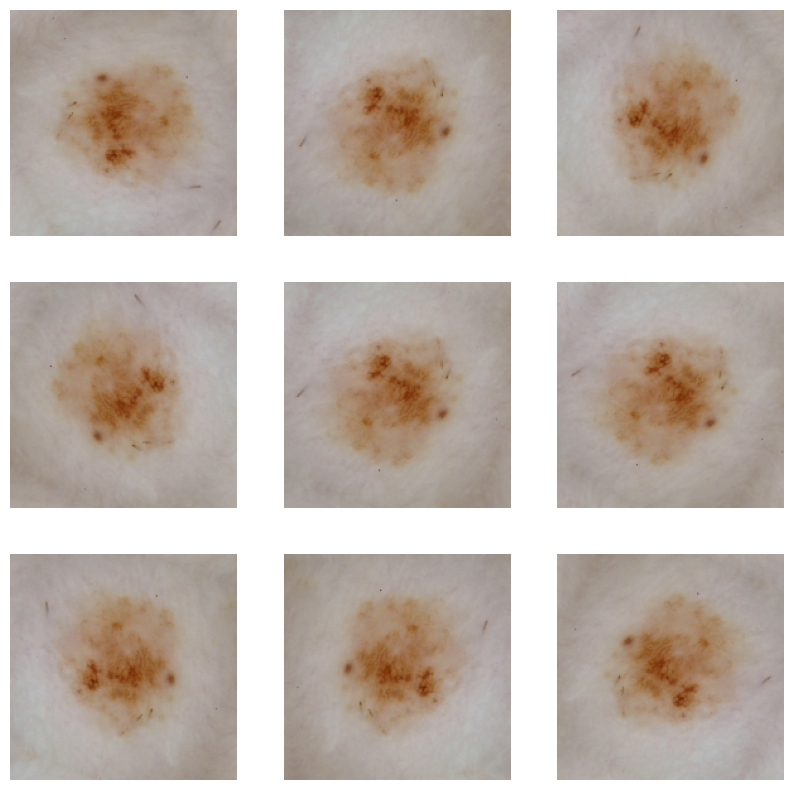

In [32]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

## Model with Data Augumentation

In [33]:
model=Sequential([data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
epochs = 20
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 9s 83ms/step - loss: 2.0590 - accuracy: 0.1892 - val_loss: 2.0723 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 2.0328 - accuracy: 0.2026 - val_loss: 2.0220 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 5s 81ms/step - loss: 1.9906 - accuracy: 0.2271 - val_loss: 1.9763 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 4s 80ms/step - loss: 1.8308 - accuracy: 0.3220 - val_loss: 1.6716 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6723 - accuracy: 0.3917 - val_loss: 1.6433 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 1.5948 - accuracy: 0.4286 - val_loss: 1.6229 - val_accuracy: 0.3982
Epoch 7/20
56/56 [==============================] - 4s 79ms/step - loss: 1.5574 - accuracy: 0.4643 - val_loss: 1.5365 - val_accuracy: 0.4743
Epoch 8/20
56/56 [======

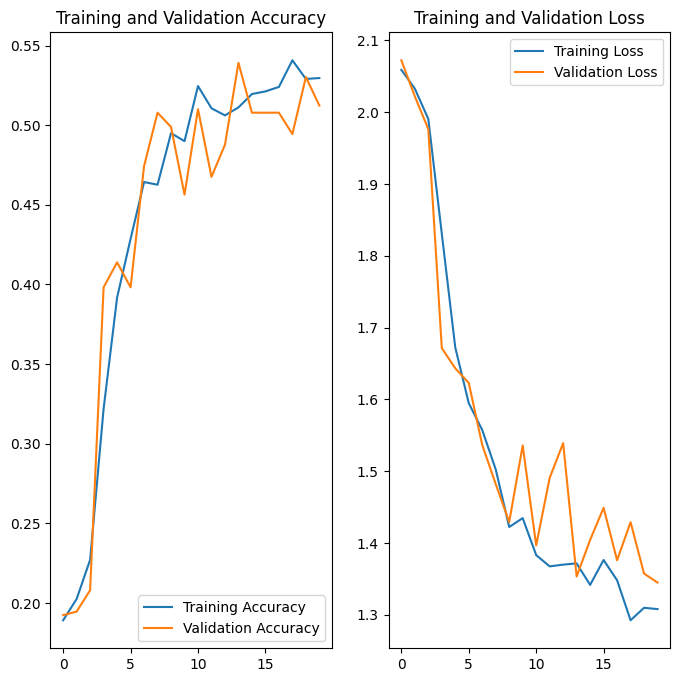

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Key Observations
The training accuracy and validation accuracy are almost equal. They follow similar trends, Although the training accuracy 52% and validation accuracy 51% has decreased. The problem of overfitting has been addressed with data augmentation as both accuracies almost follow each other.

But we have the decreased accuracies which needs to be addressed.


# Checking for class imbalance

In [40]:
# images in each Train dataset classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)

actinic keratosis:114
basal cell carcinoma:376
dermatofibroma:95
melanoma:438
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


Uneven dataset: The training dataset the distribution of image are uneven.
* seborrheic keratosis : 77
* squamous cell carcinoma : 181
* vascular lesion : 139
* actinic keratosis : 114
* dermatofibroma : 95

The samples in above cases are very less in comparison to
the other cases. So we need to increase the samples in each case.

## Augmentor for addressing class imbalance problem

In [41]:
!pip install Augmentor

  Using cached Augmentor-0.2.12-py2.py3-none-any.whl (38 kB)


In [42]:
import Augmentor

In [43]:
train_path

'/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train'

In [44]:
for i in class_names:
  print(train_path+i)

/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainactinic keratosis
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainbasal cell carcinoma
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Traindermatofibroma
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainmelanoma
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainnevus
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainpigmented benign keratosis
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainseborrheic keratosis
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainsquamous cell carcinoma
/content/gdrive/MyDrive/CNN_Melanoma_Dataset/Trainvascular lesion


In [45]:
path_to_training_dataset=train_path
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3714DDFCD0>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C3714EC9060>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3714D9A1A0>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C37B09B4B20>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C37100D0D90>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C37B0873D30>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C37B080A8F0>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C37100A5420>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3714F27BE0>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
from glob import glob

In [47]:
path_list = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [48]:
len(path_list)

4500

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [50]:
len(lesion_list_new)

4500

In [51]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:
len(dataframe_dict_new )

4500

In [53]:
class_names[0]

'actinic keratosis'

In [54]:
for i in class_names:
    directory =train_path
    directory_out =train_path+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


#### The augmentor has increased the number of samples by 500 in each of the classes. This make the difference in ratio less between each class.

# **Model with Augmented Data**

In [55]:
img_height = 180
img_width = 180

In [56]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [58]:
model=Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))

In [59]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
history = model.fit(train_ds,
          validation_data= val_ds,
          epochs=30)

Epoch 1/30
169/169 [==============================] - 43s 232ms/step - loss: 2.0987 - accuracy: 0.1843 - val_loss: 2.1223 - val_accuracy: 0.1819
Epoch 2/30
169/169 [==============================] - 38s 221ms/step - loss: 1.7313 - accuracy: 0.3231 - val_loss: 1.6021 - val_accuracy: 0.3853
Epoch 3/30
169/169 [==============================] - 43s 250ms/step - loss: 1.5150 - accuracy: 0.4160 - val_loss: 1.4490 - val_accuracy: 0.4439
Epoch 4/30
169/169 [==============================] - 37s 211ms/step - loss: 1.3961 - accuracy: 0.4627 - val_loss: 1.3467 - val_accuracy: 0.5182
Epoch 5/30
169/169 [==============================] - 37s 210ms/step - loss: 1.2514 - accuracy: 0.5206 - val_loss: 1.3246 - val_accuracy: 0.5048
Epoch 6/30
169/169 [==============================] - 38s 216ms/step - loss: 1.1815 - accuracy: 0.5493 - val_loss: 1.2283 - val_accuracy: 0.5523
Epoch 7/30
169/169 [==============================] - 39s 222ms/step - loss: 1.0404 - accuracy: 0.6113 - val_loss: 1.0615 - val_ac

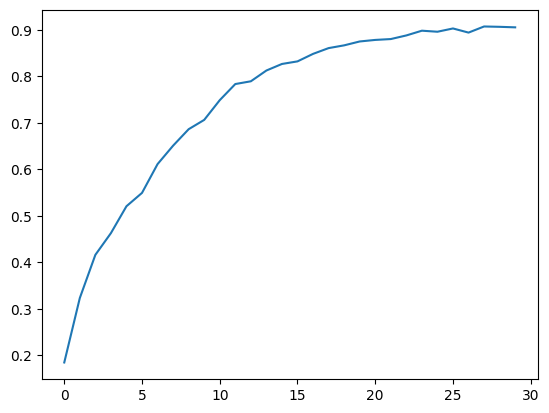

In [61]:
epochs=30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range =range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy')

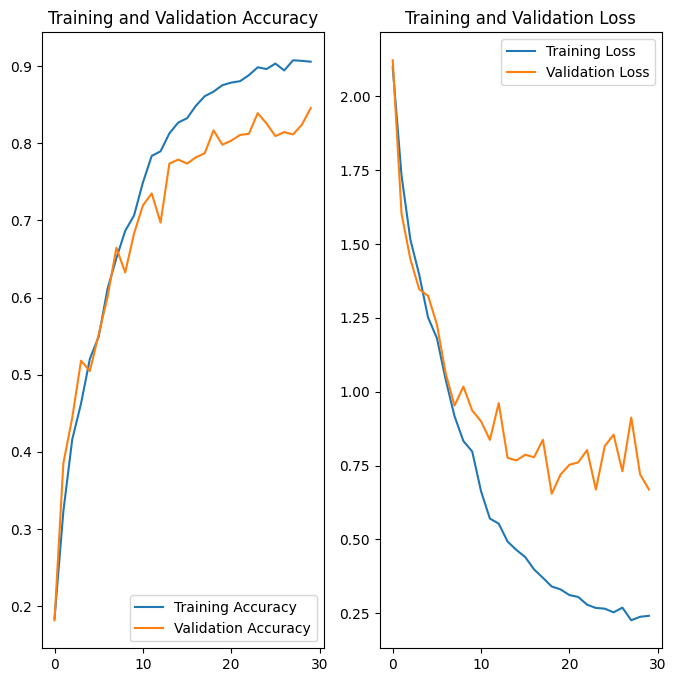

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=30
epochs_range =range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion
* The accuracy of test set is 90%
* Accuracy of validation dats set is 84%
* Here we went for some extra epochs to try if the model gets improved. But,  the model tends to increase the overfitting once we have extra epochs.
* The model with the above accuracy shows an increased performace of the model when we get a class balanced training data.
* As we can see from the model performace on the augmented data.